In [1]:
from qiskit import QuantumCircuit, transpile, assemble, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_aer import Aer

from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals

from qiskit.circuit.instruction import Instruction
from math import pi
import numpy as np
from pynverse import inversefunc
from qiskit.circuit.library import ZGate,RYGate

In [2]:
#初始化数据
x1 = np.array([0.325, 0.102, 0.28, 0.843, 0.16, 0.133, 0.125, 0.189])
x2 = np.array([[0.215, 0.004, 0.339, 0.857, 0.061, 0.17, 0.15, 0.223],
[0.829, 0.153, 0.279, 0.161, 0.065, 0.041, 0.151, 0.397],
[0.907, 0.16, 0.046, 0.052, 0.13, 0.202, 0.084, 0.289],
[0.115, 0.032, 0.355, 0.068, 0.386, 0.391, 0.622, 0.408],
[0.178, 0.345, 0.322, 0.114, 0.015, 0.004, 0.786, 0.339],
[0.061, 0.081, 0.215, 0.028, 0.777, 0.481, 0.059, 0.322]])

In [3]:
def get_degree(x1,x2):
    E = np.linalg.norm(x1, ord=2, axis=None, keepdims=False)
    F = np.linalg.norm(x2, ord=2, axis=None, keepdims=False)
    e = x1/E
    f = x2/F

    assert np.linalg.norm(e, ord=2, axis=None, keepdims=False)-1 < 1e-9
    assert np.linalg.norm(f, ord=2, axis=None, keepdims=False)-1 < 1e-9

    theta1 = float(inversefunc(np.cos, y_values=np.linalg.norm(e[:4], ord=2), domain=[0, np.pi/2]))*2
    theta2 = float(inversefunc(np.cos, y_values=np.linalg.norm(e[4:6], ord=2)/np.linalg.norm(e[4:], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    theta3 = float(inversefunc(np.cos, y_values=np.linalg.norm(e[:2], ord=2)/np.linalg.norm(e[:4], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    theta4 = float(inversefunc(np.cos, y_values=e[2]/np.linalg.norm(e[2:4], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    theta5 = float(inversefunc(np.cos, y_values=e[6]/np.linalg.norm(e[6:], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    theta6 = float(inversefunc(np.cos, y_values=e[4]/np.linalg.norm(e[4:6], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    theta7 = float(inversefunc(np.cos, y_values=e[0]/np.linalg.norm(e[:2], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2

    beta1 = float(inversefunc(np.cos, y_values=np.linalg.norm(f[:4], ord=2), domain=[0, np.pi/2]))*2
    beta2 = float(inversefunc(np.cos, y_values=np.linalg.norm(f[4:6], ord=2)/np.linalg.norm(f[4:], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    beta3 = float(inversefunc(np.cos, y_values=np.linalg.norm(f[:2], ord=2)/np.linalg.norm(f[:4], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    beta4 = float(inversefunc(np.cos, y_values=f[2]/np.linalg.norm(f[2:4], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    beta5 = float(inversefunc(np.cos, y_values=f[6]/np.linalg.norm(f[6:], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    beta6 = float(inversefunc(np.cos, y_values=f[4]/np.linalg.norm(f[4:6], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    beta7 = float(inversefunc(np.cos, y_values=f[0]/np.linalg.norm(f[:2], ord=2, axis=None, keepdims=False), domain=[0, np.pi/2]))*2
    return [[theta1,theta2,theta3,theta4,theta5,theta6,theta7], [beta1,beta2,beta3,beta4,beta5,beta6,beta7]]

In [4]:
def Us_gate(params):
    qc = QuantumCircuit(3, name="Us_gate")
    
    qc.ry(params[0],2)
    qc.cry(params[1],2,1)
    qc.x(2)
    qc.cry(params[2],2,0)

    qc.x(2)
    qc.cry(params[3],0,1)
    
    # qc.append(ccry(params[4], 2, 0, 1), range(3))
    qc.append(RYGate(params[4]).control(num_ctrl_qubits=2, ctrl_state='11'), [2, 1, 0])

    qc.x(1)
    
    qc.append(RYGate(params[5]).control(num_ctrl_qubits=2, ctrl_state='11'), [2, 1, 0])
    
    qc.x(range(3))
    
    qc.append(RYGate(params[6]).control(num_ctrl_qubits=2, ctrl_state='11'), [2, 1, 0])
    
    qc.x([0,2])
    
    return qc

def Us_layer(params):
    qc = QuantumCircuit(4, name="Us_layer")
    qc.h(0)
    qc.compose(Us_gate(params[0]).control(1, None, '1'), [0, 1,2,3], inplace=True)
    
    qc.x(0)
    qc.compose(Us_gate(params[1]).control(1, None, '1'), [0, 1,2,3], inplace=True)
    qc.x(0)
    qc.h(0)
    
    return qc

In [5]:
def Ug_layer(params):
    qc = QuantumCircuit(4, name="Ug_gate")
    qc.z(0)
    # Us_dg
    qc.compose(Us_layer(params).inverse(), range(4), inplace=True)

    qc.x(range(4))
    cccz = ZGate().control(num_ctrl_qubits=3, ctrl_state='111')
    qc.compose(cccz, [1,2,3, 0], inplace=True)
    qc.x(range(4))

    # Us
    qc.compose(Us_layer(params), range(4), inplace=True)
    
    return qc


In [6]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def qft_circuit(num_qubits):
    qft_circuit = QuantumCircuit(num_qubits, name="QFT")
    qft_circ = qft(qft_circuit, num_qubits)
    
    qc = QuantumCircuit(num_qubits)
    qc.append(qft_circ, range(num_qubits))
    return qc

def inverse_qft(num_qubits):
    qft_circuit = QuantumCircuit(num_qubits, name="QFT")
    qft_circ = qft(qft_circuit, num_qubits)
    invqft_circ = qft_circ.inverse()
    
    qc = QuantumCircuit(num_qubits)
    qc.append(invqft_circ, range(num_qubits))
    return qc

In [7]:
def GQAE_layer(orcal_qubit, aux_qubit, params):
    num_qubits = orcal_qubit + aux_qubit
    qr = QuantumRegister(num_qubits, 'q')
    cr = ClassicalRegister(aux_qubit, 'c')
    qc = QuantumCircuit(qr, cr)
    
    qc.h(range(aux_qubit))
    qc.barrier()

    qc.append(Us_layer(params), range(aux_qubit, num_qubits))
    
    reps = 1
    for i in range(aux_qubit):
        for r in range(reps):
            qc.append(Ug_layer(params).control(1, None, '1'), [i]+np.arange(aux_qubit, num_qubits).tolist())
        reps*=2
    qc.append(inverse_qft(aux_qubit), range(aux_qubit))
    qc.measure(qr[:aux_qubit], cr[:aux_qubit])
   
    return qc


In [8]:
shots = 1
orcal_qubit = 4
aux_qubit = 7
num_qubits = orcal_qubit + aux_qubit
theta = 2**(aux_qubit-1)
def get_counts(params):
    GQAE_curcuit = GQAE_layer(orcal_qubit, aux_qubit, params)
    aer_sim = Aer.get_backend('aer_simulator')
    t_circuit = transpile(GQAE_curcuit, aer_sim)
    # one measure to get results
    results = aer_sim.run(t_circuit, shots=shots).result() #direct get result from t_circuit
    counts = results.get_counts(t_circuit)    
    return counts

def q_out(y):
    inp = -np.cos(np.pi*y/theta)
    return round(float(inp),4)
def c_out(x1_,x2_):
    return round(float(np.matmul(x1_,x2_)),4)
def err_rate(qout,cout):
    return str(round(100*abs(qout - cout)/cout,4))+'%'

print('{0: <5} {1: <15} {2: <15} {3: <15} {4: <15}'.format('SN','Quant_cal','Classic_cal','Err rate','Prob'))
print('{0: <65}'.format('-'*65))
for i in range(6):
    params = get_degree(x1,x2[i])
    counts = get_counts(params)
    
    k1 = sorted(counts, key=counts.get, reverse=True)[0]
    v1 = counts[k1]
    y = int(k1 ,2)
    
    k2, v2 = 0, 0
    try:
        k2 = sorted(counts, key=counts.get, reverse=True)[1]
        v2 = counts[k2]
    except Exception as e:
        pass
    
    qout = q_out(y)
    cout = c_out(x1,x2[i])
    err = err_rate(qout,cout)
    prob = (v1+v2)/shots
    
    print('{0: <5} {1: <15} {2: <15} {3: <15}'.format(i+1, qout, cout, err))
    print('{0: <50}'.format('-'*50))


SN    Quant_cal       Classic_cal     Err rate            
------------------------------------------------------
1     0.9569          0.9809          2.4467%              
------------------------------------------------------
2     0.5957          0.6086          2.1196%              
------------------------------------------------------
3     0.4714          0.4806          1.9143%            
------------------------------------------------------
4     0.4714          0.466           1.1588%          
------------------------------------------------------
5     0.4276          0.4446          3.8237%           
------------------------------------------------------
6     0.3827          0.3684          3.8817%              
------------------------------------------------------


C:\Users\Administrator\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


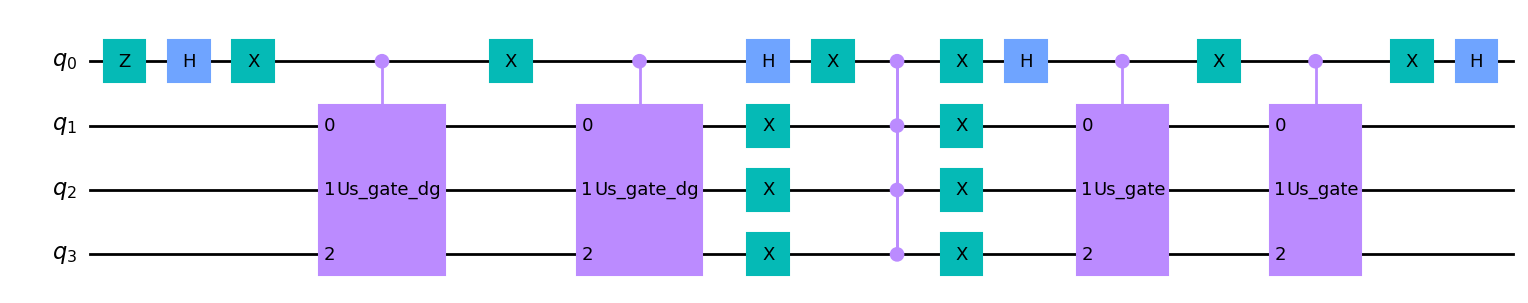

In [9]:
Ug_gate = Ug_layer(params)
Ug_gate.draw('mpl')

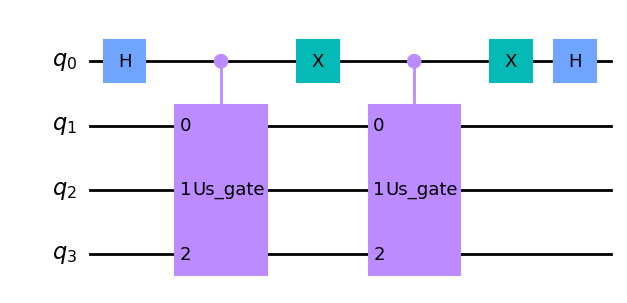

In [10]:
Us_gate = Us_layer(params)
Us_gate.draw('mpl')